Loading in initial libraries

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(patchwork)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

Loading in dataset and adding column headers to tidy up data


In [2]:
pulsar_data <- read_csv("https://raw.githubusercontent.com/KoiYouu/dcsi100_group_project/main/HTRU2/HTRU_2.csv", col_names = FALSE)
colnames(pulsar_data) <- c("Mean_of _the_integrated_profile", 
                           "Standard_deviation_of_the_integrated_profile",
                           "Excess_kurtosis_of_the_integrated_profile",
                           "Skewness_of_the_integrated_profile",
                           "Mean_of_the_DM-SNR_curve",
                           "Standard_deviation_of_the_DM-SNR_curve",
                           "Excess_kurtosis_of_the_DM-SNR_curve",
                           "Skewness_of_the_DM-SNR_curve",
                           "Class")
pulsar_data["Class"] <- lapply(pulsar_data["Class"] , factor)
pulsar_data

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Mean_of _the_integrated_profile,Standard_deviation_of_the_integrated_profile,Excess_kurtosis_of_the_integrated_profile,Skewness_of_the_integrated_profile,Mean_of_the_DM-SNR_curve,Standard_deviation_of_the_DM-SNR_curve,Excess_kurtosis_of_the_DM-SNR_curve,Skewness_of_the_DM-SNR_curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


Renaming column headers to be easier to use when coding

In [3]:
colnames(pulsar_data) <- c('mean_profile', 'std_profile', 'kurtosis_profile', 'skewness_profile', 'mean_dmsnr',
               'std_dmsnr', 'kurtosis_dmsnr', 'skewness_dmsnr', 'class')
pulsar_data

mean_profile,std_profile,kurtosis_profile,skewness_profile,mean_dmsnr,std_dmsnr,kurtosis_dmsnr,skewness_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


Creating the training / testing split

In [4]:
pulsar_split <- initial_split(pulsar_data, prop = 3/4, strata = class)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

We can see that there are 12172 observations that aren't pulsar stars, and 1251 that are in our training dataset.


In [5]:
pulsar_info <- pulsar_train %>%
    group_by(class) %>%
    summarize(n = n())
pulsar_info

class,n
<fct>,<int>
0,12177
1,1246


In [6]:
mean_profile_pulsar <- ggplot(pulsar_train, aes(x=class, y=mean_profile, fill = class)) + 
    geom_violin(width=1.4)+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Pulsar (1 = is, 0 = isn't)", y = "Mean of the integrated profile")+
    theme(text = element_text(size = 20))

std_profile_pulsar <- ggplot(pulsar_train, aes(x=class, y=std_profile, fill = class)) + 
    geom_violin(width=1.4)+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Pulsar (1 = is, 0 = isn't)", y = "Standard deviation of the integrated profile")+
    theme(text = element_text(size = 20))

kurtosis_profile_pulsar <- ggplot(pulsar_train, aes(x=class, y=kurtosis_profile, fill = class)) + 
    geom_violin(width=1.4)+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Pulsar (1 = is, 0 = isn't)", y = "Excess kurtosis of the integrated profile")+
    theme(text = element_text(size = 20))

skewness_profile_pulsar <- ggplot(pulsar_train, aes(x=class, y=skewness_profile, fill = class)) + 
    geom_violin(width=1.4)+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Pulsar (1 = is, 0 = isn't)", y = "Skewness of the integrated profile")+
    theme(text = element_text(size = 20))

mean_dmsnr_pulsar <- ggplot(pulsar_train, aes(x=class, y=mean_dmsnr, fill = class)) + 
    geom_violin(width=1.4)+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Pulsar (1 = is, 0 = isn't)", y = "Mean of the DM-SNR curve")+
    theme(text = element_text(size = 20))

std_dmsnr_pulsar <- ggplot(pulsar_train, aes(x=class, y=std_dmsnr, fill = class)) + 
    geom_violin(width=1.4)+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Pulsar (1 = is, 0 = isn't)", y = "Standard deviation of the DM-SNR curve")+
    theme(text = element_text(size = 20))

kurtosis_dmsnr_pulsar <- ggplot(pulsar_train, aes(x=class, y=kurtosis_dmsnr, fill = class)) + 
    geom_violin(width=1.4)+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Pulsar (1 = is, 0 = isn't)", y = "Excess kurtosis of the DM-SNR curve")+
    theme(text = element_text(size = 20))

skewness_dmsnr_pulsar <- ggplot(pulsar_train, aes(x=class, y=skewness_dmsnr, fill = class)) + 
    geom_violin(width=1.4)+
    geom_boxplot(width=0.1, color="black", alpha=0.6) +
    labs(x="Pulsar (1 = is, 0 = isn't)", y = "Skewness of the DM-SNR curve")+
    theme(text = element_text(size = 20))

Warning message:
“position_dodge requires non-overlapping x intervals”
Warning message:
“position_dodge requires non-overlapping x intervals”
Warning message:
“position_dodge requires non-overlapping x intervals”
Warning message:
“position_dodge requires non-overlapping x intervals”
Warning message:
“position_dodge requires non-overlapping x intervals”
Warning message:
“position_dodge requires non-overlapping x intervals”
Warning message:
“position_dodge requires non-overlapping x intervals”
Warning message:
“position_dodge requires non-overlapping x intervals”


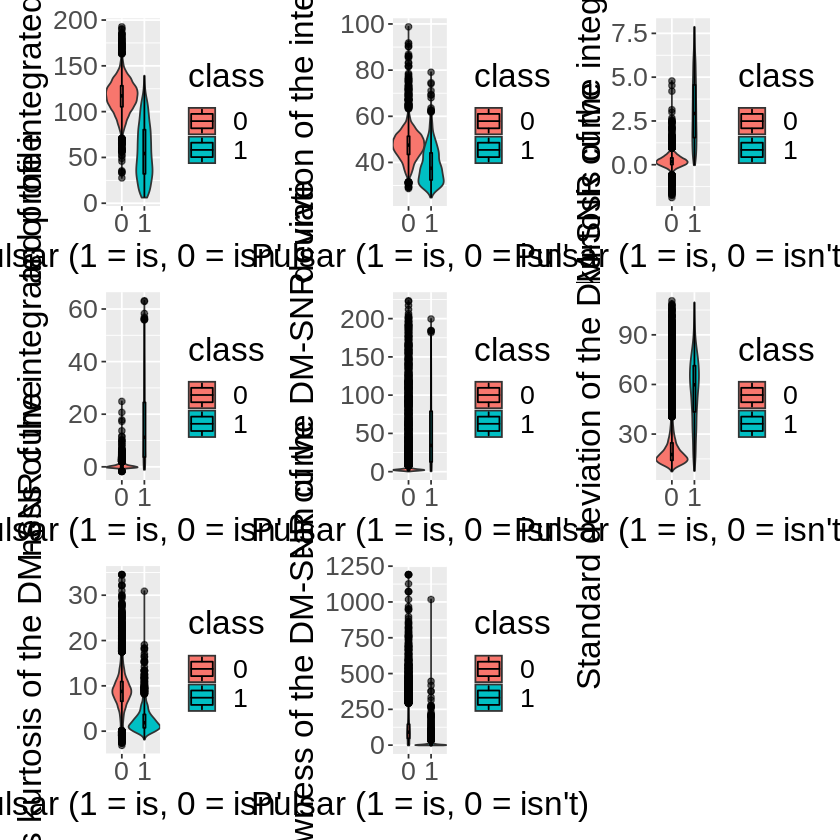

In [7]:
mean_profile_pulsar + 
std_profile_pulsar +  
kurtosis_profile_pulsar + 
skewness_profile_pulsar + 
mean_dmsnr_pulsar +
std_dmsnr_pulsar +
kurtosis_dmsnr_pulsar +
skewness_dmsnr_pulsar